## Basic RamanomeSpec Workflow

In [1]:
import sys
import os
import math
sys.path.append("/Users/zijianleowang/Desktop/GitHub/RamanomeSpec/scripts")
sys.path.append(os.path.join(".", "../scripts/OPU/opu_analysis"))
import pandas as pd
import json
import matplotlib.pyplot as plt
import Raman_read, Raman_preprocess, Raman_find_polymer, Raman_stat, Raman_plot, Raman_color, Raman_workflow, Raman_feature
import imp
import numpy as np
import plotly.io as pio
import opu_analysis_lib as oal # need to install git@github.com:lguangyu/scikit-feature.git
from scipy import stats 
import seaborn as sns

In [2]:
# Data for Zhou soil old
pathin = "/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat"
peakwindow = np.arange(1,15)
pathout = pathin+"_out"
metalevel = ['time',"treatment",'biological repetitive','repetitive']
dataloop = len(metalevel) # pathin contains layers of directory; 1st layers represents time points; end dir contains multiple txt files from LabSpec6
summary = Raman_workflow.process_spec(pathin,pathout,dataloop,metalevel,peakwindow=peakwindow)

Begin to process /Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat/Time02/Waterlogged/Rep2/Drop2_01.txt
/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat_out/Time02/Waterlogged/Rep2/Drop2_01.xlsx has been saved
/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat_out/Time02/Waterlogged/Rep2/Drop2_01.xlsx has been saved
/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat_out/Time02/Waterlogged/Rep2/Drop2_01.xlsx has been saved
/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat_out/Time02/Waterlogged/Rep2/Drop2_01.xlsx has been saved
/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat_out/OPU/Time02/Waterlogged/Rep2/Drop2_01.txt has been saved
Begin to process /Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Summer 2022 Winter Wheat/Time02/Waterlogged/Rep2/Drop1_01.txt
/Users/zijianleowang/Downloads/Cornel

## visualize the stats in the summary

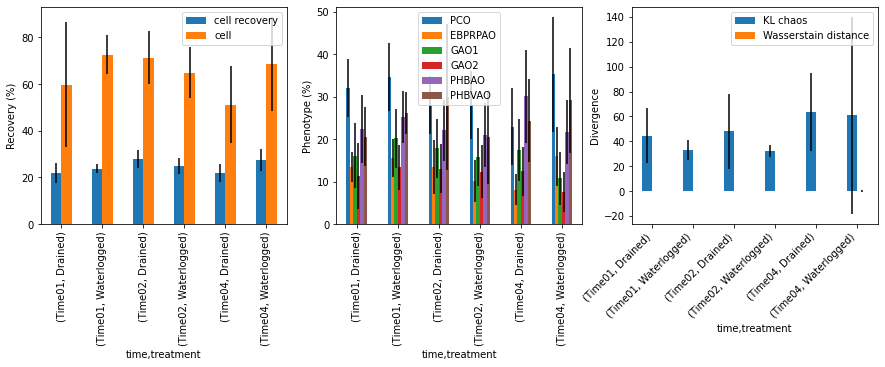

In [6]:
pathin_sum = os.path.join(pathout,"summary.xlsx")
pathout_sum = pathin_sum.replace("summary.xlsx","summary.png")
summary = pd.read_excel(pathin_sum,index_col=0)
fig, ax = Raman_plot.viz_summary(metalevel[:2],summary,figsize=(15,4),
                                 plots=[["cell recovery","cell"],\
                                        ["PCO","EBPRPAO","GAO1","GAO2","PHBAO","PHBVAO"],\
                                        ["KL chaos","Wasserstain distance"]],\
                                 labels=["Recovery (%)", "Phenotype (%)", "Divergence"])
fig.savefig(pathout_sum,bbox_inches='tight')

## plot the average and molecular distribution given a RamanLevel

In [7]:
imp.reload(Raman_workflow)
metalevel = ['time',"treatment",'biological repetitive','repetitive']
RamanLevel = metalevel[:2] # you need to determine this based on your metalevel
Ramanpathin = pathin
Ramanpathout = Ramanpathin + "_out/mean_features" # dir to save feature ranking and average images

Raman_workflow.plot_average(metalevel,RamanLevel,Ramanpathin,Ramanpathout,phenotypes=["cell","PCO","EBPRPAO","GAO1","GAO2","PHBAO","PHBVAO"])
plt.close()

TypeError: not all arguments converted during string formatting

# plot feature ranking

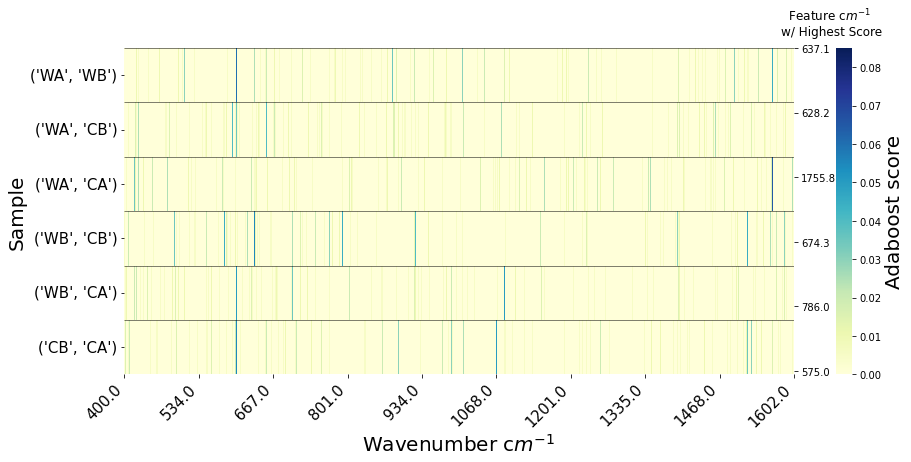

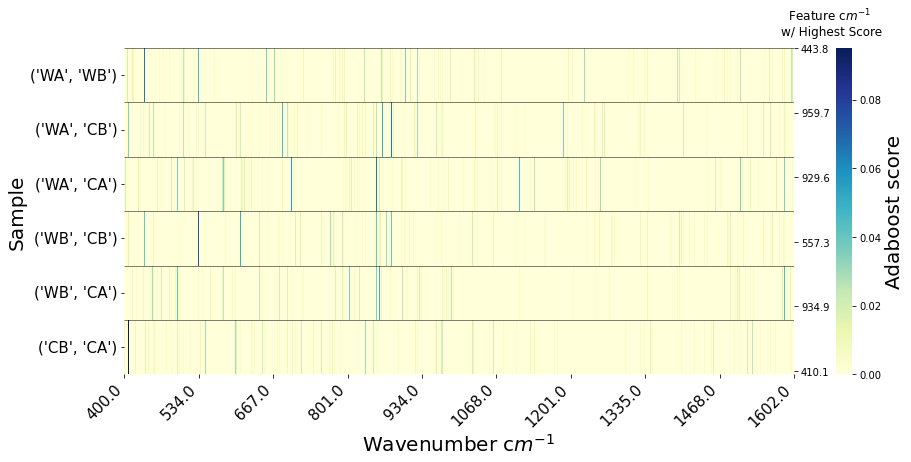

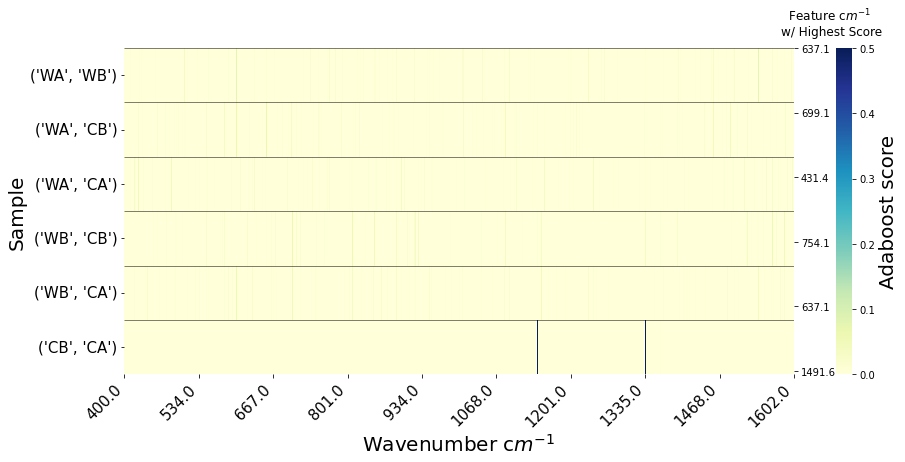

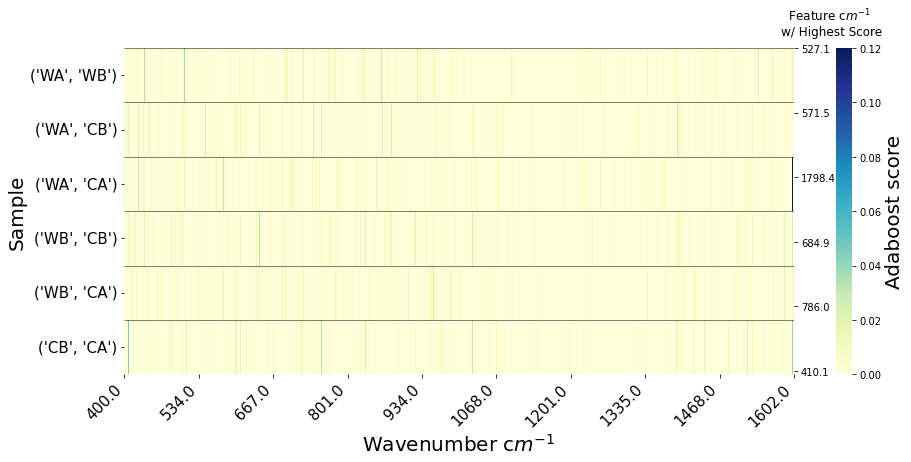

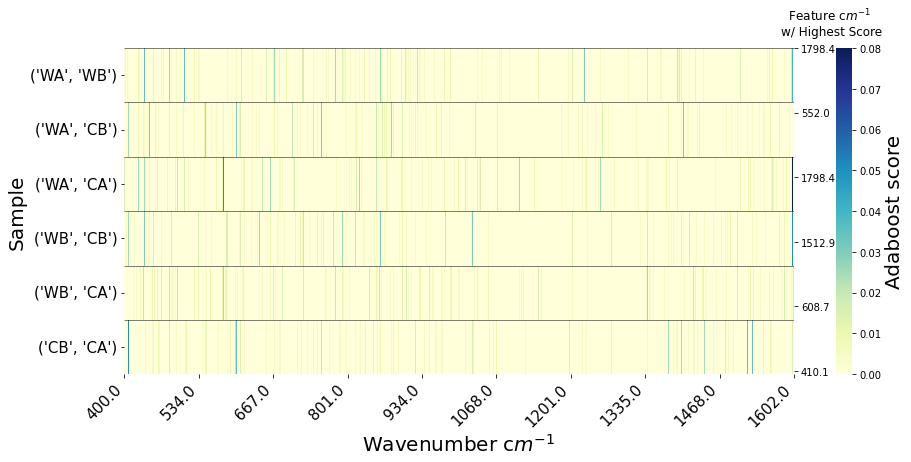

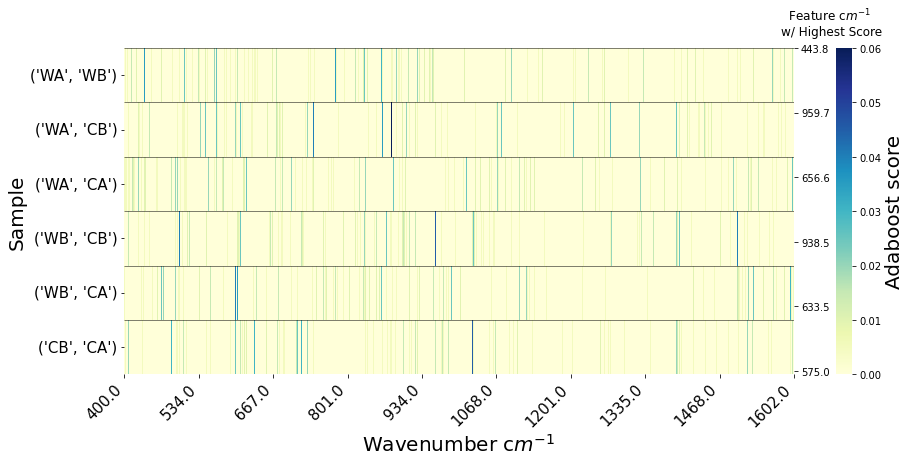

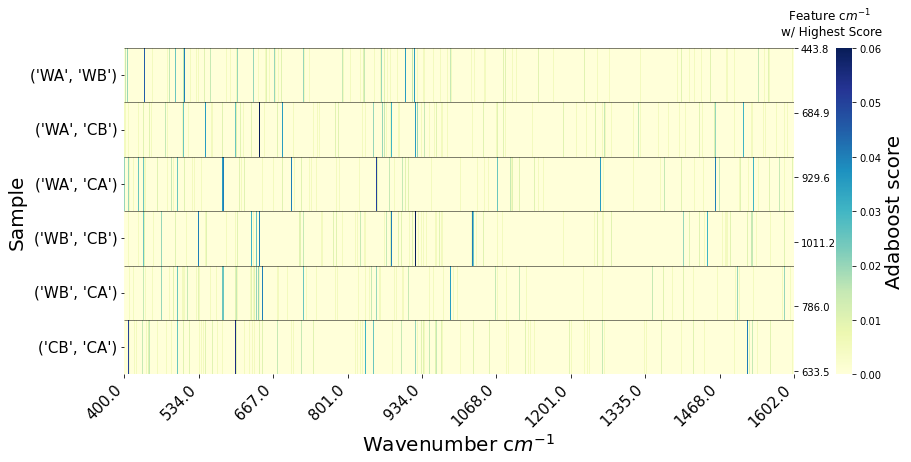

In [59]:
# models : "MI", "Lasso","Adaboost","lap","rfe","fisher"
imp.reload(Raman_feature)
dirfeature = os.path.join(Ramanpathout,"feature")
pfeature = os.listdir(dirfeature)
pfeature = [os.path.join(dirfeature,i) for i in pfeature if not i.startswith(".")]
model = "Adaboost"

for file in pfeature:
    dfi = pd.read_csv(file)
    wavenumber = dfi.iloc[0,:-1]
    X = dfi.iloc[1:,:-1].astype(float)
    Y = dfi.iloc[1:,-1]

    # reset to begin from zero because get label pair would return idx starting from 0
    X.reset_index(inplace=True,drop=True)  
    Y.reset_index(inplace=True,drop=True) 

    pairid, name = Raman_feature.get_label_pair(Y.values.tolist())
    metrics = []
    for i in range(len(pairid)):
        idxi = pairid[i][0]+pairid[i][1]
        metric = Raman_feature.Featuremodels(X.loc[idxi,:],Y[idxi],model=model,norm=None)
        metrics.append(metric)
    metrics = pd.DataFrame(metrics,index=name)

    # plot the heatmap
    fig = Raman_feature.Featureplot(metrics,wavenumber,
                              cbarname="%s score"%model,figsize=(15,6))
    pathfig = list(os.path.split(file))
    pathfig[-1] = pathfig[-1].replace(".csv",".%s.png"%model)
    pathfig[0] = os.path.join(pathfig[0],"..","fig")
    fig.savefig(os.path.join(*pathfig),
                 bbox_inches='tight',dpi=300)
    

## Run OPU Analysis

In [58]:
# Prepare all files for OPU analysis
# prepare dataset config 
# determine OPU file level and OPU path
imp.reload(Raman_workflow)
OPUlevel = metalevel[1] # you need to determine this based on your metalevel; 0, 1, :2
OPUpathin = os.path.join(pathout,"OPU")
OPUpathout = OPUpathin + "_out_%s"%("".join(OPUlevel))

# prepare parameter dictionary
params = {
    "load":{
        "bin_size": 3.0,
        "wavenum_low": 400,
        "wavenum_high": 1800,
        "normalize": "l2"},
    "HCA":{
        "metric": "cosine",
        "cutoff": 0.6,
        "max_n_opus": 0,
        "opu_min_size": 0.02 # fraction of total; lower value -> more OPU
    },
    "save":{
        "dpi": 300,
        "opulabel": os.path.join(OPUpathout,"opu_labels.txt"),
        "opucollection": os.path.join(OPUpathout,"spectra_collection"),
        "plothca":os.path.join(OPUpathout,"HCAplot.png"),
        "plotstackbar":os.path.join(OPUpathout,"stackbar.png"),
        "biplot":os.path.join(OPUpathout,"biplot.png"),
        "featuretable":os.path.join(OPUpathout,"opu.feature_rank.txt"),
        "plotfeaturerank":os.path.join(OPUpathout,"opu.feature_rank.png"),
    },
    
}
if not os.path.exists(OPUpathout):
    os.makedirs(OPUpathout)

with open(os.path.join(OPUpathout,"params_config.json"), "w") as f:
    json.dump(params, f)

#### define above
dataset_config = Raman_workflow.prep_dataset_config(metalevel,OPUlevel,OPUpathin,OPUpathout)
# run it
Raman_workflow.run_opu(dataset_config,params)

# Draw metadata

In [21]:
# draw the metadata
fig_dict1 = {"starti":5, "endi":20, "ncols":3,"continuous":"Y","showfliers":False}
pathin1 = "/Users/zijianleowang/Desktop/GitHub/EasyMicrobiome/data/ZhouSoil16S/Old/metadata2.xlsx"
by1 = "Sample name"
pathout1 = "/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Zhou soil Raman/old/2019_out/metadata.png"
sheet_name1 = "metadata"
Raman_workflow.draw_meta(fig_dict1,pathin1,by1,pathout1,sheet_name1)
plt.close()

# draw the summary file
fig_dict2 = {"starti":7, "endi":"end", "ncols":3,"continuous":"Y","showfliers":False}
pathin2 = "/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Zhou soil Raman/old/2019_out/summary.xlsx"
sheet_name2 = "summary"
by2 = "treatment"
pathout2 = "/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Zhou soil Raman/old/2019_out/Raman_summary.png"
Raman_workflow.draw_meta(fig_dict2,pathin2,by2,pathout2,sheet_name2)
plt.close()

# draw the metadata grouped
pathin3 = "/Users/zijianleowang/Desktop/GitHub/EasyMicrobiome/data/ZhouSoil16S/Old/metadata2.xlsx"
sheet_name3 = "metadata"
by3 = "Sample name"
pathout3 = "/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/Zhou soil Raman/old/2019_out/metadata_grouped.png"
Raman_workflow.draw_meta_grouped(pathin3,sheet_name3,by3,pathout3)
plt.close()